In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Overview
In this tutorial, we will work through a time series forecasting project from end-to-end, from
downloading the dataset and defining the problem to training a final model and making
predictions. This project is not exhaustive, but shows how you can get good results quickly by
working through a time series forecasting problem systematically. The steps of this project that
we will work through are as follows.
1. Problem Description.
2. Test Harness.
3. Persistence.
4. Data Analysis.
5. ARIMA Models.
6. Model Validation

In [2]:
df = pd.read_csv('./project/Project Annual Water Usage in Baltimore/dataset/yearly-water-usage.csv', index_col='Year', parse_dates=['Year'])
df.head()

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


In [3]:
df.shape

(79, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 1885-01-01 to 1963-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Water   79 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


In [5]:
df.describe()

,Water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


## Test Harness
We must develop a test harness to investigate the data and evaluate candidate models. This
involves two steps:
1. Defining a Validation Dataset.
2. Developing a Method for Model Evaluation.

### Validation Dataset
The dataset is not current. This means that we cannot easily collect updated data to validate
the model. Therefore, we will pretend that it is 1953 and withhold the last 10 years of data
from analysis and model selection. This final decade of data will be used to validate the final
model. The code below will load the dataset as a Pandas Series and split into two, one for
model development (dataset.csv) and the other for validation (validation.csv).

In [6]:
split_point = len(df) - 10
dataset, validation = df[:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

dataset.to_csv('./project/Project Annual Water Usage in Baltimore/dataset/dataset.csv')
validation.to_csv('./project/Project Annual Water Usage in Baltimore/dataset/validation.csv')

Dataset 69, Validation 10


## Persistence

The first step before getting bogged down in data analysis and modeling is to establish a baseline
of performance. This will provide both a template for evaluating models using the proposed
test harness and a performance measure by which all more elaborate predictive models can be
compared. The baseline prediction for time series forecasting is called the naive forecast, or
persistence.

In [7]:
from sklearn.metrics import mean_squared_error

dataset = pd.read_csv('./project/Project Annual Water Usage in Baltimore/dataset/dataset.csv', index_col='Year', parse_dates=['Year'])
X = dataset.values.astype('float32').flatten()
train_size = int(len(X) * .5)
train, test = X[:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []

for i in range(len(test)):
    # predict
    y_pred = history[-1]
    predictions.append(y_pred)
    # observation
    obs = test[i]
    history.append(obs)
    print(f'Predicted={y_pred}, Expected={obs}')
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE test score: {rmse}')

Predicted=503.0, Expected=503.0
Predicted=503.0, Expected=503.0
Predicted=503.0, Expected=515.0
Predicted=515.0, Expected=522.0
Predicted=522.0, Expected=492.0
Predicted=492.0, Expected=503.0
Predicted=503.0, Expected=503.0
Predicted=503.0, Expected=450.0
Predicted=450.0, Expected=432.0
Predicted=432.0, Expected=432.0
Predicted=432.0, Expected=458.0
Predicted=458.0, Expected=462.0
Predicted=462.0, Expected=503.0
Predicted=503.0, Expected=488.0
Predicted=488.0, Expected=466.0
Predicted=466.0, Expected=492.0
Predicted=492.0, Expected=503.0
Predicted=503.0, Expected=515.0
Predicted=515.0, Expected=500.0
Predicted=500.0, Expected=522.0
Predicted=522.0, Expected=575.0
Predicted=575.0, Expected=583.0
Predicted=583.0, Expected=587.0
Predicted=587.0, Expected=628.0
Predicted=628.0, Expected=640.0
Predicted=640.0, Expected=609.0
Predicted=609.0, Expected=606.0
Predicted=606.0, Expected=632.0
Predicted=632.0, Expected=617.0
Predicted=617.0, Expected=613.0
Predicted=613.0, Expected=598.0
Predicte

We now have a baseline prediction method and performance; now we can start digging into
our data.

## Data Analysis
We can use summary statistics and plots of the data to quickly learn more about the structure
of the prediction problem. In this section, we will look at the data from four perspectives:
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.

### Summary Statistics

Summary statistics provide a quick look at the limits of observed values. It can help to get a
quick idea of what we are working with. The example below calculates and prints summary
statistics for the time series.

In [8]:
# summary statistics of time series
dataset.describe()

,Water
count,69.000000
mean,500.478261
std,73.901685
min,344.000000
25%,458.000000
50%,492.000000
75%,538.000000
max,662.000000


Running the example provides a number of summary statistics to review. Some observations
from these statistics include:
* The number of observations (count) matches our expectation, meaning we are handling the data correctly.
* The mean is about 500, which we might consider our level in this series.
* The standard deviation and percentiles suggest a reasonably tight spread around the mean.

### Line Plot
A line plot of a time series dataset can provide a lot of insight into the problem. The example
below creates and shows a line plot of the dataset.

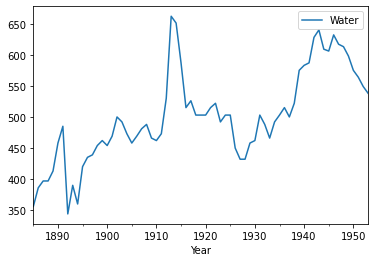

In [9]:
dataset.plot()
plt.show()

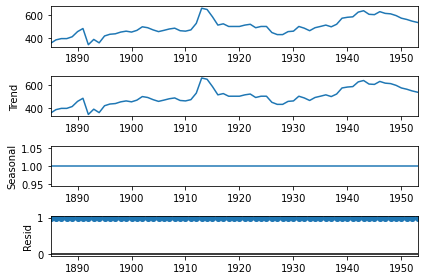

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataset, model='multiplicative')
_ = result.plot()

Run the example and review the plot. Note any obvious temporal structures in the series.
Some observations from the plot include:
* There looks to be an increasing trend in water usage over time.
* There do not appear to be any obvious outliers, although there are some large fluctuations.
* There is a downward trend for the last few years of the series.

### Density Plot
Reviewing plots of the density of observations can provide further insight into the structure of
the data. The example below creates a histogram and density plot of the observations without
any temporal structure.

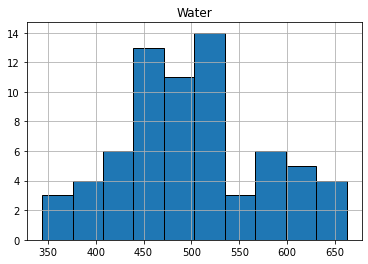

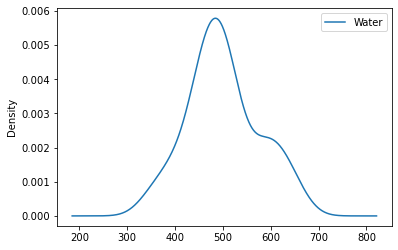

In [11]:
dataset.hist(edgecolor='k')
plt.show()
dataset.plot(kind='kde')
plt.show()

Run the example and review the plots. Some observations from the plots include:
* The distribution is not Gaussian, but is pretty close.
* The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dataset)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.267303
p-value: 0.182730
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


### Box and Whisker Plots
We can group the annual data by decade and get an idea of the spread of observations for each
decade and how this may be changing. We do expect to see some trend (increasing mean or
median), but it may be interesting to see how the rest of the distribution may be changing. The
example below groups the observations by decade and creates one box and whisker plot for
each decade of observations. The last decade only contains 9 years and may not be a useful
comparison with the other decades. Therefore only data between 1885 and 1944 was plotted.

In [13]:
years = list(dataset.index.year)

year_grouping = {}
count = 10
for i in range(int(len(years) / 10) + 1):
    year_grouping[i+1] = years[count-10:count]
    count += 10
year_grouping

{1: [1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894],
 2: [1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904],
 3: [1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914],
 4: [1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924],
 5: [1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934],
 6: [1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944],
 7: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953]}

In [14]:
dataset

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1949-01-01,598
1950-01-01,575
1951-01-01,564


,1885,1895,1905,1915,1925,1935
0,356,420,458,587,503,503
1,386,435,469,515,450,515
2,397,439,481,526,432,500
3,397,454,488,503,432,522
4,413,462,466,503,458,575
5,458,454,462,503,462,583
6,485,469,473,515,503,587
7,344,500,530,522,488,628
8,390,492,662,492,466,640
9,360,473,651,503,492,609


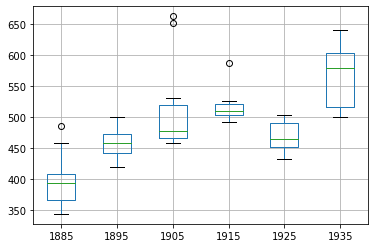

In [15]:
groups = dataset.resample('10YS')
decades = pd.DataFrame()

for index, group in groups:
    if len(group.values) == 10:
        decades[index.year] = group.values.flatten()

display(decades)
decades.boxplot()
plt.show()

Running the example creates 6 box and whisker plots side-by-side, one for the 6 decades of
selected data. Some observations from reviewing the plot include:
* The median values for each year (red line) may show an increasing trend that may not be linear.
* The spread, or middle 50% of the data (blue boxes), does show some variability.
* There maybe outliers in some decades (crosses outside of the box and whiskers).
* The second to last decade seems to have a lower average consumption, perhaps related to the first world war.

### ARIMA Models
In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models
for the problem. We will approach modeling by both manual and automatic configuration of
the ARIMA model. This will be followed by a third step of investigating the residual errors of
the chosen model. As such, this section is broken down into 3 steps:
1. Manually Configure the ARIMA.
2. Automatically Configure the ARIMA.
3. Review Residual Errors.

### Manually Configured ARIMA
The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.
Analysis of the time series data assumes that we are working with a stationary time series. The
time series is likely non-stationary. We can make it stationary by first differencing the series
and using a statistical test to confirm that the result is stationary. The example below creates a
stationary version of the series and saves it to file stationary.csv.

In [50]:
from statsmodels.tsa.stattools import adfuller

def print_result(data):
    print('ADF Statistic: %f' % data[0])
    print('p-value: %f' % data[1])
    print('Critical Values:')
    for key, value in data[4].items():
        print('\t%s: %.3f' % (key, value))

dataset['Diff'] = dataset.diff()
X = dataset['Diff'][1:].values.astype('float32')

result_1 = adfuller(X)
result_2 = adfuller(dataset['Water'])

print_result(result_1)

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


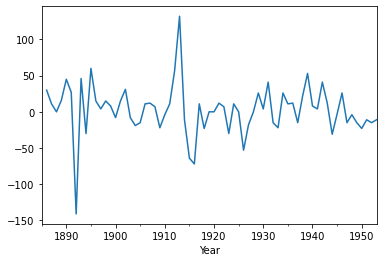

In [17]:
dataset['Diff'].plot()
plt.show()
dataset['Diff'].to_csv('./project/Project Annual Water Usage in Baltimore/dataset/stationary.csv', header=False)

Running the example outputs the result of a statistical significance test of whether the
differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show
that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This
suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a
low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

This suggests that at least one level of differencing is required. The d parameter in our
ARIMA model should at least be a value of 1. A plot of the differenced data is also created. It
suggests that this has indeed removed the increasing trend.

The next first step is to select the lag values for the Autoregression (AR) and Moving Average
(MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function
(ACF) and Partial Autocorrelation Function (PACF) plots. The example below creates ACF
and PACF plots for the series.

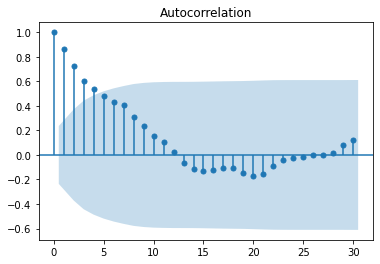

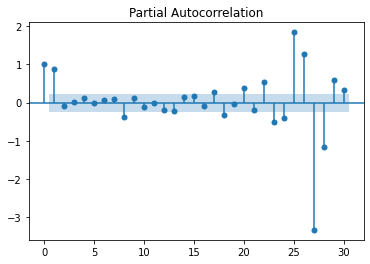

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_acf(dataset['Water'], lags=30)
plt.show()
_ = plot_pacf(dataset['Water'], lags=30)
plt.show()

Run the example and review the plots for insights into how to set the p and q variables for
the ARIMA model. Below are some observations from the plots.
* The ACF shows significant lags to 4 time steps.
* The PACF shows significant lags to 1 time step.
A good starting point for the p is 4 and q is 1.

In [19]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

X = dataset['Water'].values.astype('float32')
train_size = int(len(X) * .5)
train, test = X[:train_size], X[train_size:]

# walk validation
history = [x for x in train]
predictions = []

for i in range(len(test)):
    #predict
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit(disp=0)
    y_pred = model_fit.forecast()[0]
    predictions.append(y_pred)
    
    # observation    
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (y_pred, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE test score: {rmse}')

>Predicted=548.319, Expected=503.000
>Predicted=545.085, Expected=503.000
>Predicted=546.061, Expected=515.000
>Predicted=550.660, Expected=522.000
>Predicted=552.011, Expected=492.000
>Predicted=519.221, Expected=503.000
>Predicted=527.953, Expected=503.000
>Predicted=534.026, Expected=450.000
>Predicted=474.119, Expected=432.000
>Predicted=456.458, Expected=432.000
>Predicted=465.408, Expected=458.000
>Predicted=481.425, Expected=462.000
>Predicted=476.155, Expected=503.000
>Predicted=511.083, Expected=488.000
>Predicted=497.183, Expected=466.000
>Predicted=460.301, Expected=492.000
>Predicted=506.310, Expected=503.000
>Predicted=515.928, Expected=515.000
>Predicted=516.368, Expected=500.000
>Predicted=504.364, Expected=522.000
>Predicted=525.885, Expected=575.000
>Predicted=579.358, Expected=583.000
>Predicted=575.313, Expected=587.000
>Predicted=573.357, Expected=628.000
>Predicted=622.135, Expected=640.000
>Predicted=632.300, Expected=609.000
>Predicted=595.782, Expected=606.000
>

## Grid Search ARIMA Hyperparameters
The ACF and PACF plots suggest that we cannot do better than a persistence model on this
dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and
check that no models result in better out-of-sample RMSE performance. In this section, we will
search values of p, d, and q for combinations (skipping those that fail to converge), and find
the combination that results in the best performance. We will use a grid search to explore all
combinations in a subset of integer values. Specifically, we will search all combinations of the
following parameters:

* p: 0 to 4.
* d: 0 to 2.
* q: 0 to 4.

This is (5 $\times$ 3 $\times$ 5), or 300 potential runs of the test harness, and will take some time to
execute. We will also disable the automatic addition of a trend constant from the model by
setting the trend argument to nc for no constant when calling fit(). The complete worked
example with the grid search version of the test harness is listed below.

In [21]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * .5)
    train, test = X[:train_size], X[train_size:]
    
    # make predictions
    history = [x for x in train]
    predictions = []
    
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
#         model_fit = model.fit(trend='nc', disp=0)
        model_fit = model.fit(disp=0)
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        
        obs = test[i]
        history.append(obs)
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(dataset['Water'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=76.755
ARIMA(0, 0, 1) RMSE=47.346
ARIMA(0, 0, 2) RMSE=36.048
ARIMA(0, 0, 3) RMSE=32.587
ARIMA(0, 1, 0) RMSE=22.311
ARIMA(0, 1, 1) RMSE=22.258
ARIMA(0, 1, 2) RMSE=28.430
ARIMA(0, 1, 3) RMSE=30.054
ARIMA(0, 2, 0) RMSE=29.335
ARIMA(0, 2, 1) RMSE=23.072
ARIMA(0, 2, 2) RMSE=22.954
ARIMA(0, 2, 3) RMSE=23.374
ARIMA(1, 0, 0) RMSE=23.958
ARIMA(1, 0, 1) RMSE=23.998
ARIMA(1, 0, 2) RMSE=25.412
ARIMA(1, 0, 3) RMSE=30.529
ARIMA(1, 1, 0) RMSE=22.270
ARIMA(1, 2, 0) RMSE=27.786
ARIMA(1, 2, 1) RMSE=22.979
ARIMA(2, 0, 0) RMSE=24.131
ARIMA(2, 0, 1) RMSE=24.140
ARIMA(2, 1, 0) RMSE=22.084
ARIMA(2, 2, 0) RMSE=25.616
ARIMA(2, 2, 3) RMSE=25.607
ARIMA(3, 0, 0) RMSE=24.183
ARIMA(3, 0, 1) RMSE=24.555
ARIMA(3, 1, 0) RMSE=25.060
ARIMA(3, 1, 1) RMSE=32.092
ARIMA(3, 2, 0) RMSE=26.126
ARIMA(3, 2, 1) RMSE=25.594
Best ARIMA(2, 1, 0) RMSE=22.084


Running the example runs through all combinations and reports the results on those that
converge without error. The example takes a little over 2 minutes to run on modern hardware.
The results show that the best configuration discovered was ARIMA(2,1,0) with an RMSE
of 21.733, slightly lower than the persistence model tested earlier, but may or may not be

## Review Residual Errors
A good final check of a model is to review residual forecast errors. Ideally, the distribution of
residual errors should be a Gaussian with a zero mean. We can check this by using summary
statistics and plots to investigate the residual errors from the ARIMA(2,1,0) model. The example
below calculates and summarizes the residual forecast errors.

RMSE: 22.417356505678118


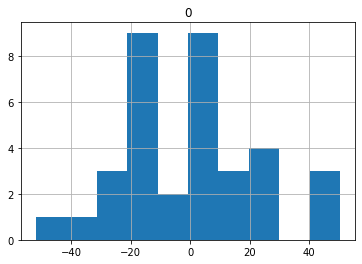

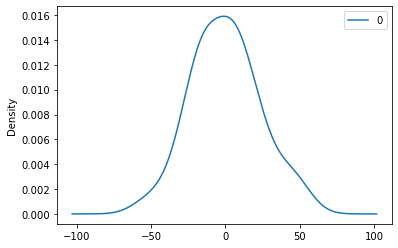

In [45]:
X = dataset['Water'].values.astype('float32')
train_size = int(len(X) * .5)
train, test = X[:train_size], X[train_size:]

# walk forward validation
history = [x for x in X]
predictions = []

for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    y_pred = model_fit.forecast()[0]
    predictions.append(y_pred)
    
    # obervation
    obs = test[i]
    history.append(obs)
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

# errors
residuals = [test[i] - predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

residuals.hist()
plt.show()

residuals.plot(kind='kde')
plt.show()

In [46]:
residuals.describe()

,0
count,35.000000
mean,-0.007629
std,22.744633
min,-51.927855
25%,-16.709941
50%,0.435007
75%,11.491881
max,50.417785


Running the example first describes the distribution of the residuals. We can see that the
distribution has a right shift and that the mean is non-zero at -0.00763. This is perhaps a sign
that the predictions are biased.

The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like
distribution with a longer right tail, providing further evidence that perhaps a power transform
might be worth exploring.

We could use this information to bias-correct predictions by adding the mean residual error
of -0.00763 to each forecast made. The example below performs this bias-correction.

RMSE: 21.732992484229293


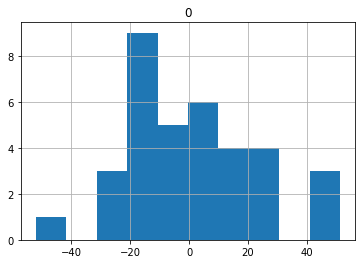

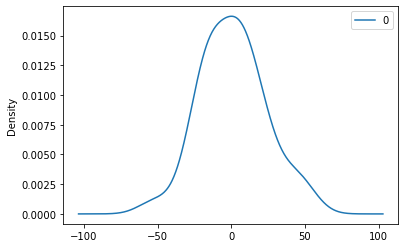

In [47]:
X = dataset['Water'].values.astype('float32')

train_size = int(len(X) * .5)
train, test = X[:train_size], X[train_size:]

# walk forward validation
history = [x for x in train]
predictions = []
bias = -0.00763

for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    y_pred = bias + float(model_fit.forecast()[0])
    predictions.append(y_pred)
    
    # obs
    obs = test[i]
    history.append(obs)
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

residuals = [test[i] - predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

residuals.hist()
plt.show()
residuals.plot(kind='kde')
plt.show()

In [48]:
residuals.describe()

,0
count,35.000000
mean,1.089254
std,22.022567
min,-52.096181
25%,-16.194656
50%,-0.452176
75%,12.092722
max,51.291963


## Model Validation
After models have been developed and a final model selected, it must be validated and finalized.
Validation is an optional part of the process, but one that provides a last check to ensure we
have not fooled or misled ourselves. This section includes the following steps:

* Finalize Model: Train and save the final model.
* Make Prediction: Load the finalized model and make a prediction.
* Validate Model: Load and validate the final model.

## Finalize Model

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on
a transformed version of the entire dataset. Once fit, the model can be saved to file for later
use. The example below trains an ARIMA(2,1,0) model on the dataset and saves the whole fit
object and the bias to file. There is a bug in the current version of the Statsmodels library that
results in an error when you try to load a saved ARIMA model from file.

In [54]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

# prepare data
X = dataset['Water'].values.astype('float32')

# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = -0.00763

# save model
model_fit.save('./project/Project Annual Water Usage in Baltimore/model/model.pkl')
np.save('./project/Project Annual Water Usage in Baltimore/model/model_bias.npy', bias)

Running the example creates two local files:
* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coeficients and all other internal data returned when fitting the model.
* model bias.npy This is the bias value stored as a one-row, one-column NumPy array.

## Make Prediction
A natural case may be to load the model and make a single forecast. This is relatively
straightforward and involves restoring the saved model and the bias and calling the forecast()
function. The example below loads the model, makes a prediction for the next time step, and
prints the prediction.

In [58]:
from statsmodels.tsa.arima_model import ARIMAResults

model_fit = ARIMAResults.load('./project/Project Annual Water Usage in Baltimore/model/model.pkl')
bias = np.load('./project/Project Annual Water Usage in Baltimore/model/model_bias.npy')
y_pred = bias + float(model_fit.forecast()[0])
print(f'Predicted: {y_pred}')

Predicted: 538.9242073262301
